# SQL Tools für Data Science

In [ ]:
# Hilfsfunktionen laden und ...
from util.sqlite_util import *

# ... Test-Datenbank öffnen
path = get_connection_path("chinook.sqlite")
connection = create_connection(path)

Connection to SQLite DB 2.6.0 (./data/chinook.sqlite) successful


## Data Manipulation Language (DML)

Mit DML können Daten in ein existierendes Schema eingefügt, angepasst und gelöscht werden. Die Hauptbefehle sind
* INSERT 
* UPDATE
* DELETE
* (REPLACE) - wird hier nicht behandelt

### INSERT

In [ ]:
stmt = """
INSERT INTO artists (name) 
VALUES('Bud Powell');
"""
cur = execute_query(connection, stmt)
# INSERT hat keinen Rückgabewert

In [ ]:
# small helper class
def __print_artists():
    stmt = """
    SELECT
        ArtistId,
        Name
    FROM
        Artists
    ORDER BY
        ArtistId DESC
    LIMIT 3;
    """
    cur = execute_query(connection, stmt)
    print_results(cur)

__print_artists()

['ArtistId', 'Name']
(288, 'Bud Powell')
(275, 'Philip Glass Ensemble')
(274, 'Nash Ensemble')


### UPDATE

In [ ]:
stmt = """
UPDATE artists
SET name = 'Baden Powell'
WHERE name = 'Bud Powell' 
LIMIT 1;
"""
cur = execute_query(connection, stmt)

__print_artists()

['ArtistId', 'Name']
(288, 'Baden Powell')
(275, 'Philip Glass Ensemble')
(274, 'Nash Ensemble')


### DELETE

In [ ]:
stmt = """
DELETE FROM artists
WHERE name LIKE "%Powell%";
"""
cur = execute_query(connection, stmt)

__print_artists()

['ArtistId', 'Name']
(275, 'Philip Glass Ensemble')
(274, 'Nash Ensemble')
(273, 'C. Monteverdi, Nigel Rogers - Chiaroscuro; London Baroque; London Cornett & Sackbu')


### Tabelle kopieren

In [ ]:
# Zuerst verwenden wir DDL, um eine neue, leeere Tabelle zu kreieren
stmt = """
CREATE TABLE artists_backup(
   ArtistId INTEGER PRIMARY KEY AUTOINCREMENT,
   Name NVARCHAR
);
"""
execute_query(connection, stmt)

# falls die Tabelle bereits exisitert, gibt es hier eine Fehlermeldung. 
# Um dies zu unterdrücken, kann CREATE TABLE IF NOT EXISTS verwendet werden. Mache ich hier bewusst nicht.

# nun wird die Tabelle 'artists' kopiert
stmt = """
INSERT INTO artists_backup 
SELECT ArtistId, Name
FROM artists;
"""
execute_query(connection, stmt)

# zeige anzahl reihen in artists_Backup
cur = execute_query(connection, "SELECT count(*) FROM artists_backup;")
print(cur.fetchone())

# und lösche artists_backup wieder
cur = execute_query(connection, "DROP TABLE artists_backup;")

(274,)


## Data Definition Language
DDL wird verwendet, um Datenschematas zu erzeugen, ändern und löschen. Die wichtigsten Befehle sind:
* CREATE TABLE
* UPDATE TABLE
* DROP TABLE

In [ ]:
# Wir wechseln zur Test-Datenbank
connection.close()
# ... Test-Datenbank öffnen
path = get_connection_path("sql_kurs.sqlite")
connection = create_connection(path)

Connection to SQLite DB 2.6.0 (./data/sql_kurs.sqlite) successful


Folgende Beispieldatenbank wird hier erzeugt
![Beispielsdatenbank](./img/SQLite-Foreign-Key-Example.png)

In [ ]:
stmt="""
CREATE TABLE supplier_groups (
	group_id integer PRIMARY KEY,
	group_name text NOT NULL
);
"""
execute_query(connection, stmt)

stmt ="""
CREATE TABLE suppliers (
    supplier_id   INTEGER PRIMARY KEY,
    supplier_name TEXT    NOT NULL,
    group_id      INTEGER NOT NULL,
    FOREIGN KEY (group_id)
       REFERENCES supplier_groups (group_id) 
);
"""
execute_query(connection, stmt)


print(show_tables(connection))
print("\nDetails zur Tabelle 'suppliers':")
print(desc_table(connection, "suppliers"))



['contacts', 'groups', 'contact_groups', 'supplier_groups', 'suppliers']

Details zur Tabelle 'suppliers':
CREATE TABLE suppliers (
    supplier_id   INTEGER PRIMARY KEY,
    supplier_name TEXT    NOT NULL,
    group_id      INTEGER NOT NULL,
    FOREIGN KEY (group_id)
       REFERENCES supplier_groups (group_id) 
)


In [ ]:
# und wir löschen die Tabellen wieder
execute_query(connection, "drop table if exists supplier_groups")
execute_query(connection, "drop table if exists suppliers")
print(show_tables(connection))

['contacts', 'groups', 'contact_groups']


## Aufgabe 13: DDL und DML

Gegeben ist folgendes Datenbankschema.

![Datenbank-Schema](./img/SQLite-CREATE-TABLE-example.jpg)

* a) Benutze CREATE TABLE, um das Schema zu erzeugen.
* b) Fülle die Tabelle mit einigen Beispieldaten mit INSERT INTO
* c) Lösche die Tabellen mit DROP TABLE
* d) Zeige alle Contacts mit den zugewiesenen Gruppe in einer Tabelle.

In [ ]:
# c) Lösche die Tabellen mit DROP TABLE
execute_query(connection, "DROP TABLE IF EXISTS groups")
execute_query(connection, "DROP TABLE IF EXISTS contacts")
execute_query(connection, "DROP TABLE IF EXISTS contact_groups")
print(show_tables(connection))

[]


In [ ]:
# a) Benutze CREATE TABLE, um das Schema zu erzeugen.
stmt = """
CREATE TABLE IF NOT EXISTS contacts (
	contact_id INTEGER PRIMARY KEY,
	first_name TEXT NOT NULL,
	last_name TEXT NOT NULL,
	email TEXT NOT NULL UNIQUE,
	phone TEXT NOT NULL UNIQUE
);"""
execute_query(connection, stmt)


stmt = """
CREATE TABLE IF NOT EXISTS groups (
   group_id INTEGER PRIMARY KEY,
   name TEXT NOT NULL
);"""
execute_query(connection, stmt)


stmt ="""
CREATE TABLE IF NOT EXISTS contact_groups(
   contact_id INTEGER,
   group_id INTEGER,
   PRIMARY KEY (contact_id, group_id),
   FOREIGN KEY (contact_id) 
      REFERENCES contacts (contact_id) 
         ON DELETE CASCADE 
         ON UPDATE NO ACTION,
   FOREIGN KEY (group_id) 
      REFERENCES groups (group_id) 
         ON DELETE CASCADE 
         ON UPDATE NO ACTION
);"""
execute_query(connection, stmt)
print(show_tables(connection))


['contacts', 'groups', 'contact_groups']


In [ ]:
# b) Fülle die Tabelle mit einigen Beispieldaten mit INSERT INTO
stmt = """
INSERT INTO groups (name)
VALUES ("privat"), ("business"), ("familie"), ("freizeit");"""
execute_query(connection, stmt)
cur = execute_query(connection, "SELECT * FROM groups;")
print_results(cur)

['group_id', 'name']
(1, 'privat')
(2, 'business')
(3, 'familie')
(4, 'freizeit')


In [ ]:
stmt = """
INSERT INTO contacts (first_name, last_name, email, phone)
VALUES ("marco", "soldati", "marco@abc.de", "02280808080"),
       ("max", "frisch", "max@fris.ch", "0229911991"),
       ("alain", "berset", "aberset@ch.ch", "032*******");
"""
execute_query(connection, stmt)
cur = execute_query(connection, "SELECT * FROM contacts;")
print_results(cur)

['contact_id', 'first_name', 'last_name', 'email', 'phone']
(1, 'marco', 'soldati', 'marco@abc.de', '02280808080')
(2, 'max', 'frisch', 'max@fris.ch', '0229911991')
(3, 'alain', 'berset', 'aberset@ch.ch', '032*******')


In [ ]:
stmt = """
INSERT INTO contact_groups (contact_id, group_id)
VALUES (1, 1),
       (1, 3),
       (2, 4),
       (3, 2);
"""
execute_query(connection, stmt)
cur = execute_query(connection, "SELECT * FROM contact_groups;")
print_results(cur)

['contact_id', 'group_id']
(1, 1)
(1, 3)
(2, 4)
(3, 2)


In [ ]:
# d) Zeige alle Contacts mit den zugewiesenen Gruppe in einer Tabelle.
stmt = """
SELECT contact_id, first_name, last_name, email, phone, g.name FROM 
  contacts c
    INNER JOIN contact_groups cg USING(contact_id)
    INNER JOIN groups g USING(group_id)
;
"""
cur= execute_query(connection, stmt)
print_results(cur)

['contact_id', 'first_name', 'last_name', 'email', 'phone', 'name']
(1, 'marco', 'soldati', 'marco@abc.de', '02280808080', 'privat')
(1, 'marco', 'soldati', 'marco@abc.de', '02280808080', 'familie')
(2, 'max', 'frisch', 'max@fris.ch', '0229911991', 'freizeit')
(3, 'alain', 'berset', 'aberset@ch.ch', '032*******', 'business')


In [ ]:
# und wir löschen die Tabellen wieder
execute_query(connection, "drop table if exists contact_groups")
execute_query(connection, "drop table if exists contacts")
execute_query(connection, "drop table if exists groups")
print(show_tables(connection))

[]


## Pandas

In [ ]:
connection.close()
# Wechseln wir nochmals zur Chinook Datenbank...
path = get_connection_path("chinook.sqlite")
connection = create_connection(path)

NameError: name 'connection' is not defined

In [ ]:
import pandas as pd
stmt = """
SELECT ar.name, al.title, t.name, t.composer, t.milliseconds, t.bytes, t.unitPrice FROM 
  tracks t
    INNER JOIN albums al USING(albumid)
    INNER JOIN artists ar USING(artistid)
;
"""
df = pd.read_sql_query(stmt, connection)

# Verify that result of SQL query is stored in the dataframe
print(df.head())


    Name                                  Title  \
0  AC/DC  For Those About To Rock We Salute You   
1  AC/DC  For Those About To Rock We Salute You   
2  AC/DC  For Those About To Rock We Salute You   
3  AC/DC  For Those About To Rock We Salute You   
4  AC/DC  For Those About To Rock We Salute You   

                                      Name  \
0  For Those About To Rock (We Salute You)   
1                    Put The Finger On You   
2                          Let's Get It Up   
3                         Inject The Venom   
4                               Snowballed   

                                    Composer  Milliseconds     Bytes  \
0  Angus Young, Malcolm Young, Brian Johnson        343719  11170334   
1  Angus Young, Malcolm Young, Brian Johnson        205662   6713451   
2  Angus Young, Malcolm Young, Brian Johnson        233926   7636561   
3  Angus Young, Malcolm Young, Brian Johnson        210834   6852860   
4  Angus Young, Malcolm Young, Brian Johnson        2031

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TrackId       3503 non-null   int64  
 1   Name          3503 non-null   object 
 2   AlbumId       3503 non-null   int64  
 3   MediaTypeId   3503 non-null   int64  
 4   GenreId       3503 non-null   int64  
 5   Composer      2525 non-null   object 
 6   Milliseconds  3503 non-null   int64  
 7   Bytes         3503 non-null   int64  
 8   UnitPrice     3503 non-null   float64
 9   Title         3503 non-null   object 
 10  ArtistId      3503 non-null   int64  
 11  Name          3503 non-null   object 
dtypes: float64(1), int64(7), object(4)
memory usage: 328.5+ KB
None


In [ ]:
print(df.describe())

           TrackId      AlbumId  MediaTypeId      GenreId  Milliseconds  \
count  3503.000000  3503.000000  3503.000000  3503.000000  3.503000e+03   
mean   1752.000000   140.929489     1.208393     5.725378  3.935992e+05   
std    1011.373324    81.775395     0.580443     6.190204  5.350054e+05   
min       1.000000     1.000000     1.000000     1.000000  1.071000e+03   
25%     876.500000    70.500000     1.000000     1.000000  2.072810e+05   
50%    1752.000000   141.000000     1.000000     3.000000  2.556340e+05   
75%    2627.500000   212.000000     1.000000     7.000000  3.216450e+05   
max    3503.000000   347.000000     5.000000    25.000000  5.286953e+06   

              Bytes    UnitPrice     ArtistId  
count  3.503000e+03  3503.000000  3503.000000  
mean   3.351021e+07     1.050805    93.955181  
std    1.053925e+08     0.239006    53.571166  
min    3.874700e+04     0.990000     1.000000  
25%    6.342566e+06     0.990000    53.000000  
50%    8.107896e+06     0.990000    

<AxesSubplot:>

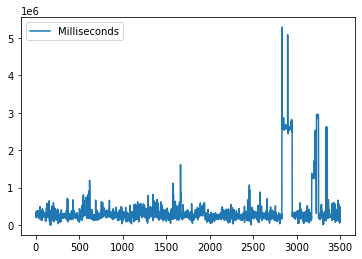

In [ ]:
df.plot.line(y=["Milliseconds"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0715ae06-549d-47db-ade6-5afadbf2cba1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>